In [1]:
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


Files already downloaded and verified
Files already downloaded and verified


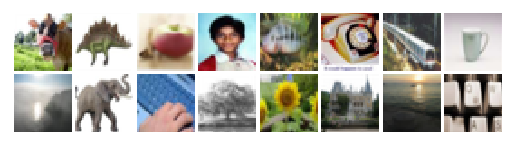

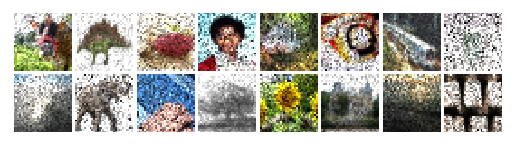

In [2]:
def add_noise(x):
    noise_amount = 0.1+0.3 * torch.rand(len(x)).to(device)
    noised = torch.normal(
       mean=torch.ones([1, 1, *x.shape[2:]], device=device),
       std=noise_amount.view(len(x), 1, 1, 1))
    return torch.clamp(x*noised, 0.0, 1.0)


traindata = datasets.CIFAR100('data', train=True, download=True, transform=transforms.ToTensor())
testdata = datasets.CIFAR100('data', train=False, download=True, transform=transforms.ToTensor())
dataloader = torch.utils.data.DataLoader(traindata, batch_size=16)

for x, y in dataloader:
    x = x.to(device)
    break

def plot_imgs(x):
    plt.figure()
    plt.imshow(np.transpose(vutils.make_grid(x[:16].cpu(),
        padding=2, pad_value=1, normalize=True), (1, 2, 0)),
                interpolation='nearest')
    plt.axis("off")
    plt.show()

plot_imgs(x)
plot_imgs(add_noise(x))

In [3]:
def conv3(nin, nout):
    return torch.nn.Conv2d(nin, nout, 3, padding=1, bias=False)

def relu(x):
    return F.relu(x, inplace=True)

class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = conv3(3, 16)
        self.conv2 = conv3(16, 16)
        self.conv3 = conv3(16, 3)

    def forward(self, input):
        x = input
        c1 = self.conv1(x)
        x = relu(c1)
        c2 = self.conv2(x)
        x = relu(c2)
        c3 = self.conv3(x)
        return c3+input

model = Model().to(device)
print(model)

Model(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv3): Conv2d(16, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
)


1000 0.044209517538547516 0.051160961389541626


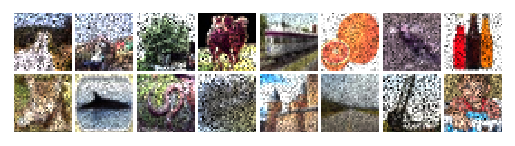

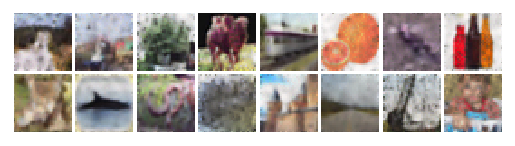

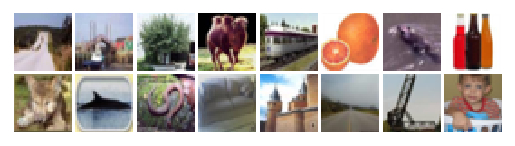

2000 0.03901023790240288 0.053022973239421844


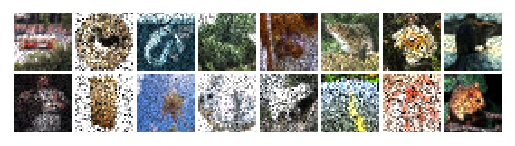

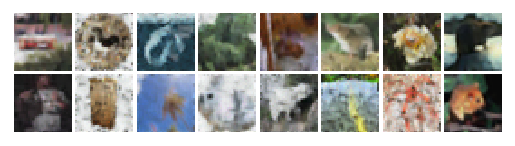

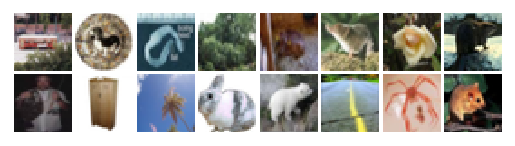

3000 0.04663340374827385 0.044973548501729965


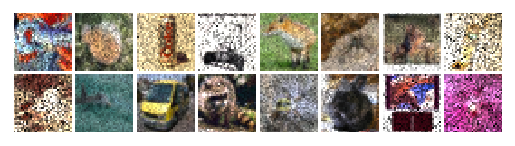

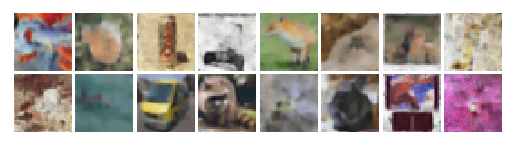

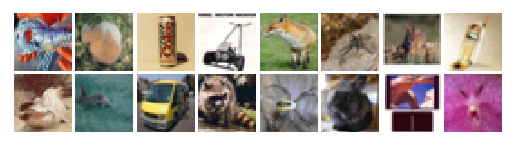

4000 0.04500485584139824 0.0495217889547348


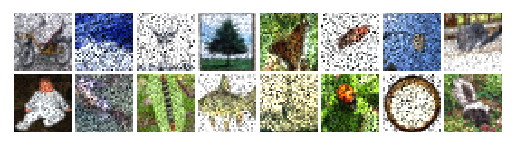

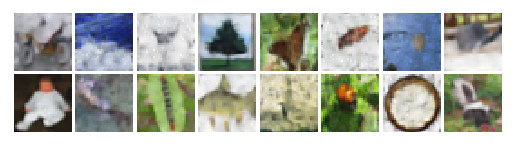

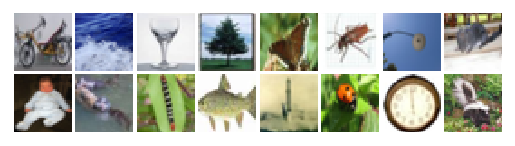

5000 0.044169895350933075 0.053354695439338684


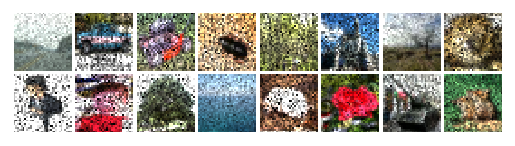

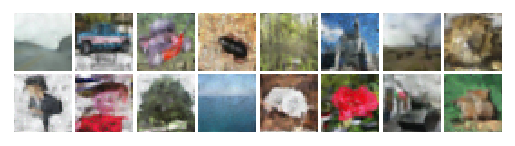

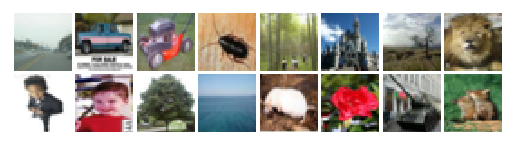

6000 0.04407395422458649 0.045845091342926025


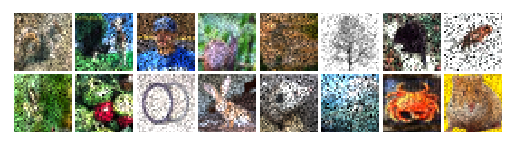

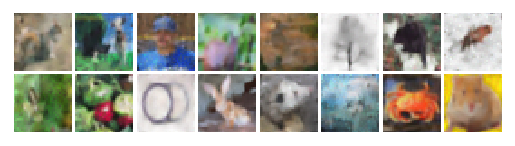

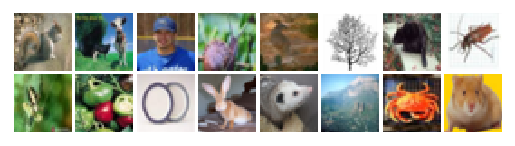

7000 0.039616357535123825 0.041946761310100555


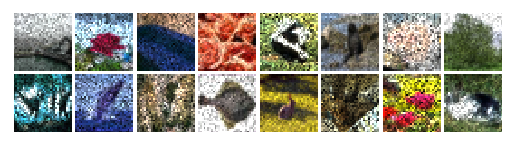

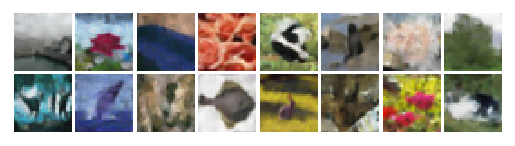

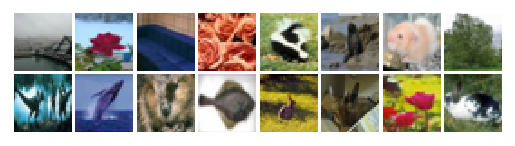

8000 0.043369751423597336 0.03701372444629669


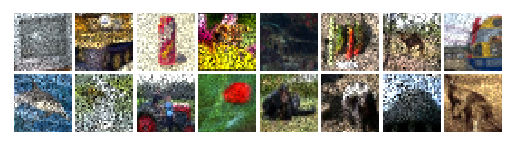

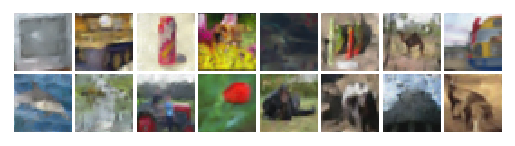

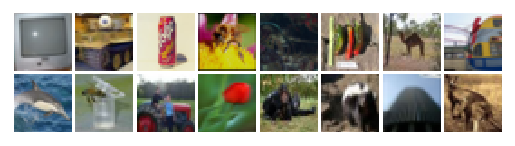

9000 0.04584997892379761 0.05104707181453705


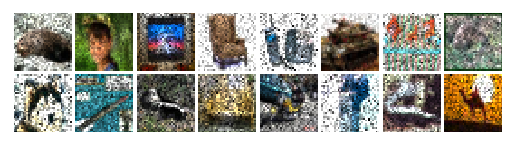

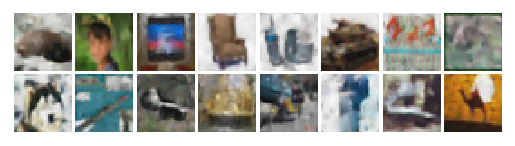

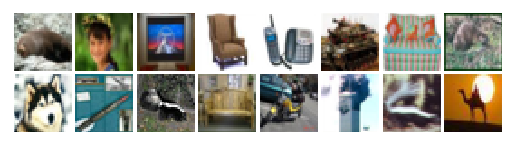

10000 0.03446419537067413 0.04009634256362915


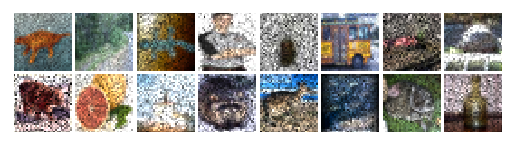

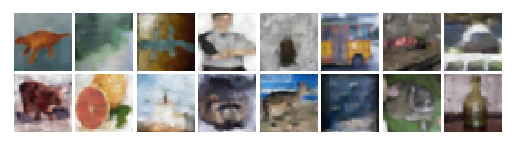

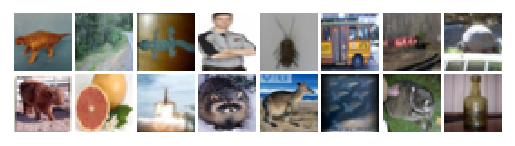

11000 0.045556407421827316 0.04993017762899399


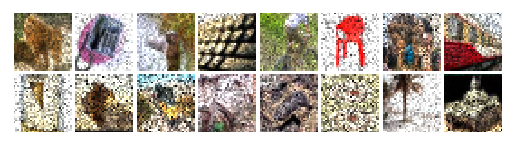

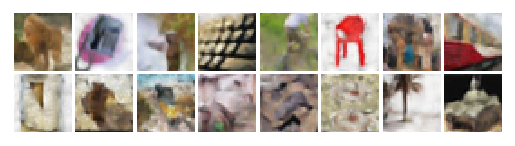

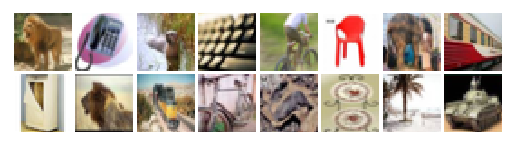

12000 0.04721992462873459 0.04212987422943115


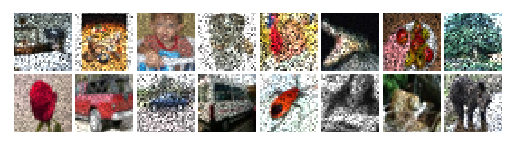

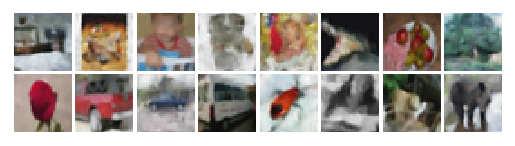

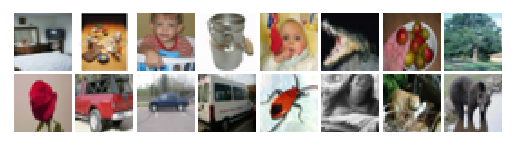

13000 0.0473611056804657 0.04722397029399872


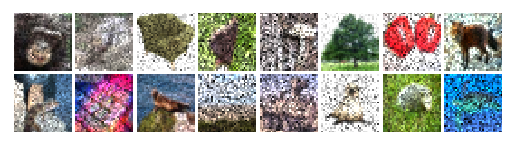

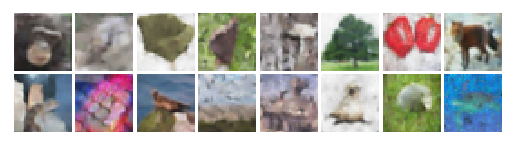

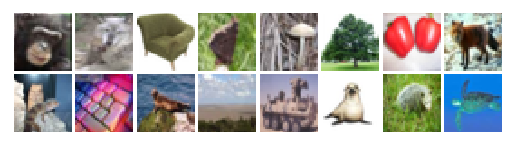

14000 0.04438742995262146 0.040798675268888474


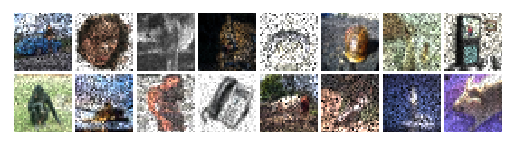

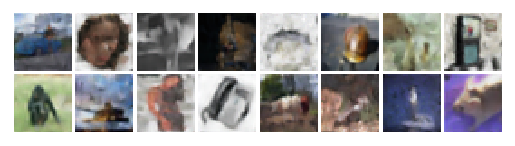

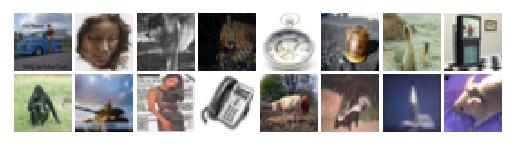

15000 0.03630845248699188 0.03986679017543793


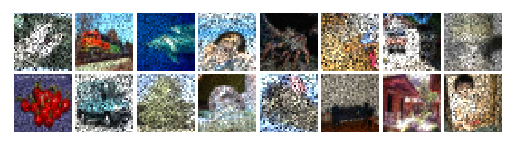

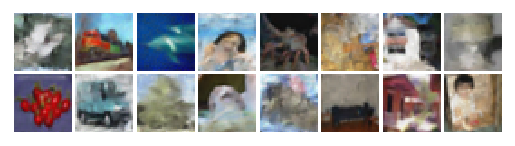

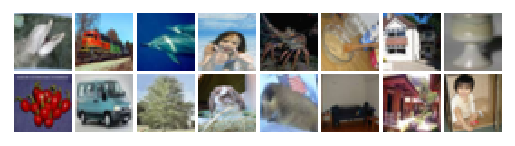

In [4]:
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.0005
)

def lossfun(x, y):
    return torch.mean(torch.abs(y-x))

batch_count = 0
for epoch in range(5):
    trainloader = torch.utils.data.DataLoader(traindata, batch_size=16)
    for images, label in trainloader:
        images = images.to(device)
        noised = add_noise(images)
        optimizer.zero_grad()
        output = model(noised)
        loss = lossfun(output, images)
        loss.backward()
        optimizer.step()

        batch_count += 1
        if batch_count % 1000 == 0:
            testloader = torch.utils.data.DataLoader(
                testdata, batch_size=16, shuffle=True)
            with torch.no_grad():
                for images, label in testloader:
                    images = images.to(device)
                    noised = add_noise(images)
                    output = model(noised)
                    loss1 = lossfun(output, images)
                    print(batch_count, loss.item(), loss1.item())
                    plot_imgs(noised)
                    plot_imgs(output)
                    plot_imgs(images)
                    break
